# 优化速度场+力场
# （完成）（效果还可以）

In [1]:
from phi.torch.flow import *
import tqdm

device = torch.device('cuda')
BOUNDS = Box(x=1, y=1)
RESOLUTION = 100


@jit_compile
def step(v, s, dt, inflow):
    s = advect.mac_cormack(s, v, dt) + 0.2 * resample(inflow, to=s, soft=True)
    buoyancy = resample(s * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, _ = fluid.make_incompressible(v, (), Solve('auto', 1e-3))
    return v, s


v0 = StaggeredGrid(
    values=0,
    extrapolation=extrapolation.ZERO,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)
smoke0 = CenteredGrid(
    values=0,
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)
inflow0 = Sphere(x=0.5, y=0.15, radius=0.1)

vel, smoke = v0, smoke0
vel_list = []
smoke_list = []
for _ in tqdm.trange(100):
    vel, smoke = step(vel, smoke, 0.2, inflow0)
    vel_list.append(vel)
    smoke_list.append(smoke)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\imeho\Documents\VituralEnvs\InstantPINF-TCNN\Lib\site-packages\phiml\backend\torch\_torch_backend.py:803: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)
100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


C:\Users\imeho\Documents\VituralEnvs\InstantPINF-TCNN\Lib\site-packages\phi\vis\_matplotlib\_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


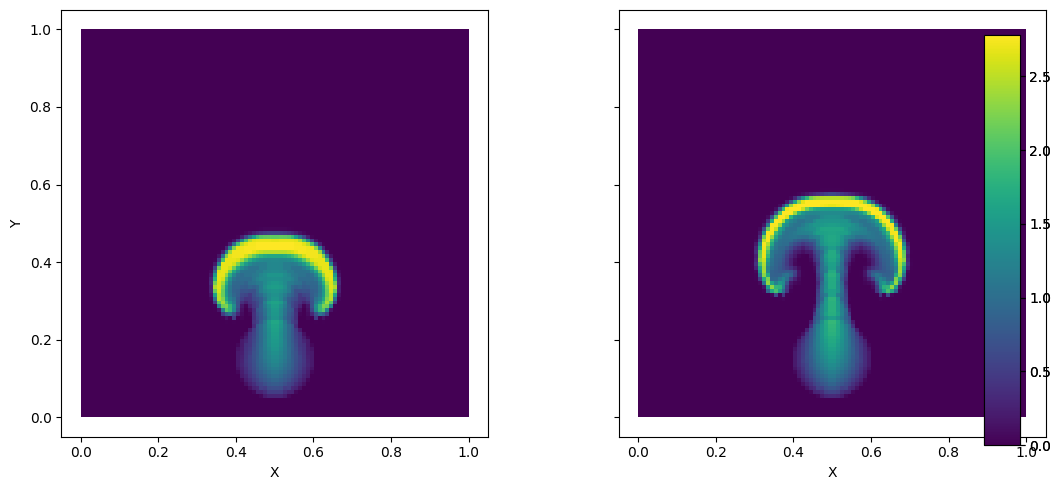

In [2]:
sim_iters = 5
smoke_record_start = smoke_list[20]
smoke_record_end = smoke_list[20 + sim_iters]
_ = plot(smoke_record_start, smoke_record_end)


def step(v, s, fr, dt, ir, inflow):
    s = advect.mac_cormack(s, v, dt) + ir * resample(inflow, to=s, soft=True)
    v = advect.semi_lagrangian(v, v, dt) + dt * fr
    return v, s


@jit_compile
def loss_function(in_vel, in_den, in_force, in_dt, in_inflow_rate, in_inflow):
    iter_v = in_vel
    iter_s = in_den
    for _ in range(sim_iters):
        iter_v, iter_s = step(iter_v, iter_s, in_force, in_dt, in_inflow_rate, in_inflow)
    return math.l2_loss(iter_s.values - smoke_record_end.values)


grad_fun = math.gradient(loss_function, wrt='in_vel, in_force', get_output=True)


def gradient_descent_step(in_vel, in_den, in_force, in_dt, in_inflow_rate, in_inflow, learning_rate=.0001):
    out_loss, (d_vel, d_fr) = grad_fun(in_vel, in_den, in_force, in_dt, in_inflow_rate, in_inflow)
    return out_loss, in_vel - learning_rate * d_vel, in_force - 0.05 * learning_rate * d_fr

In [3]:
velocity_to_train = StaggeredGrid(
    values=0,
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)
force_to_train = StaggeredGrid(
    values=0,
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)
losses = []
for _ in tqdm.trange(100):
    loss, velocity_to_train, force_to_train = gradient_descent_step(velocity_to_train, smoke_record_start,
                                                                    force_to_train, 0.2, 0.2, inflow0)
    losses.append(loss)

100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


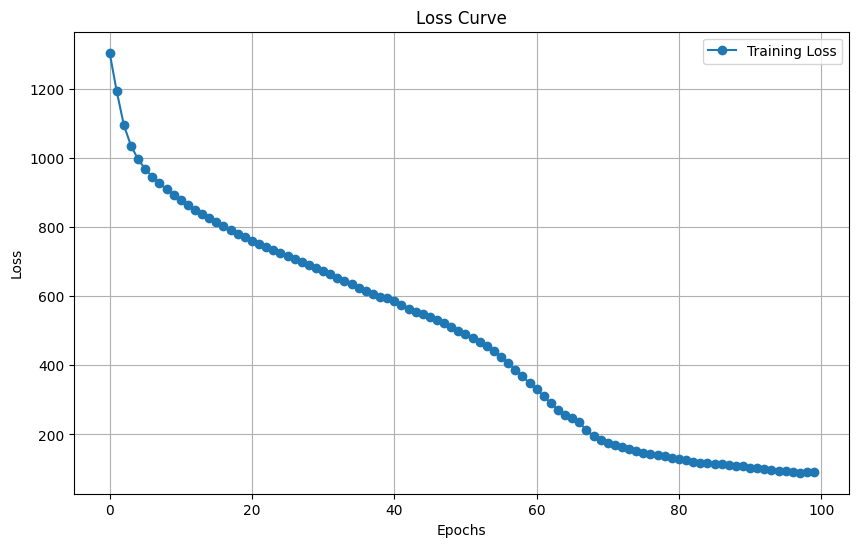

In [4]:
import matplotlib.pyplot as plt

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss", linestyle='-', marker='o')  # 使用线条和标记
plt.xlabel("Epochs")  # 横轴标签
plt.ylabel("Loss")  # 纵轴标签
plt.title("Loss Curve")  # 图标题
plt.legend()  # 显示图例
plt.grid(True)  # 添加网格
plt.show()

In [5]:
iter_v = velocity_to_train
iter_s = smoke_record_start
for _ in tqdm.trange(sim_iters):
    iter_v, iter_s = step(iter_v, iter_s, force_to_train, 0.2, 0.2, inflow0)

100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


C:\Users\imeho\Documents\VituralEnvs\InstantPINF-TCNN\Lib\site-packages\phi\vis\_matplotlib\_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


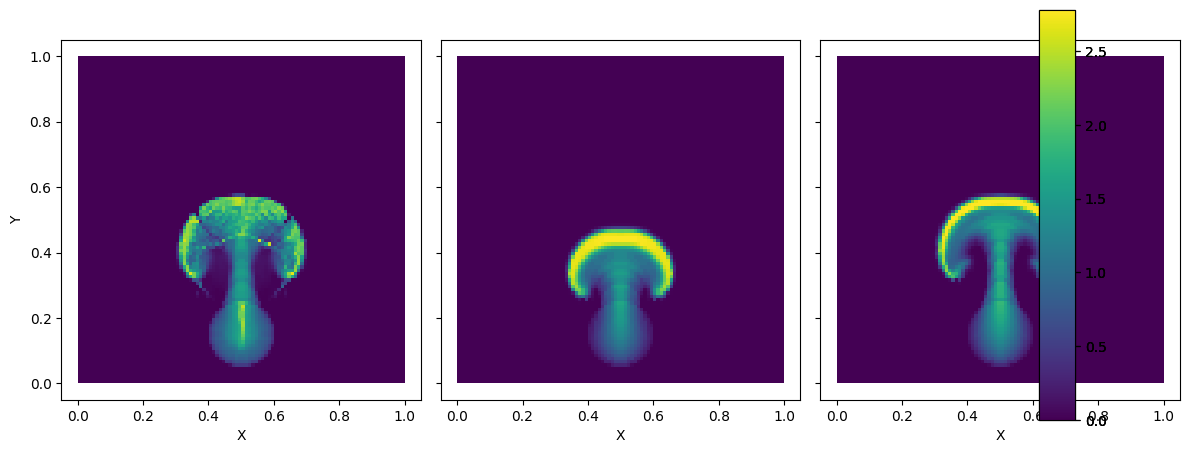

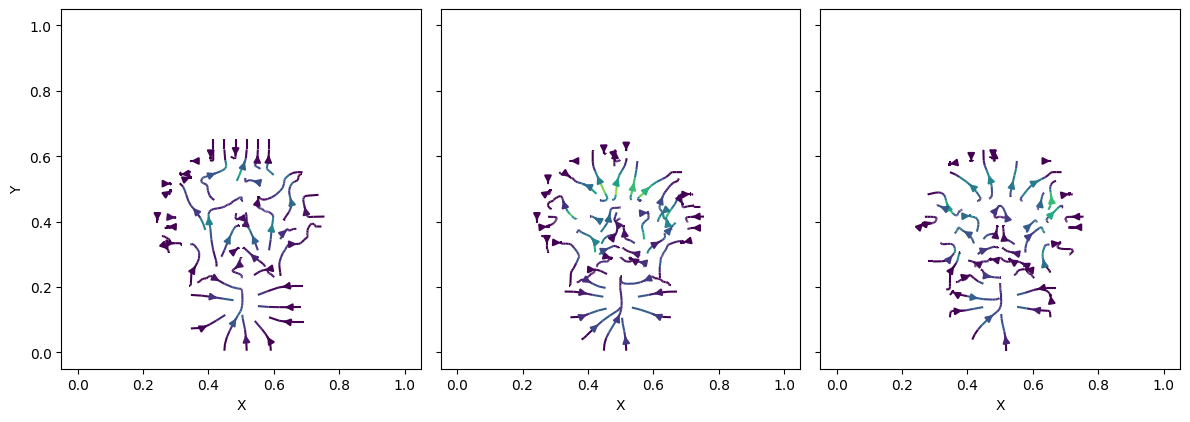

In [6]:
_ = plot(iter_s, smoke_record_start, smoke_record_end)
_ = plot(iter_v, velocity_to_train, force_to_train)